This report details the process of building, training, and evaluating a facial emotion recognition model using the FER13 dataset and PyTorch. 
- The goal is to classify facial images into one of seven emotion categories. Two model variations based on the EfficientNet V2 Small architecture are explored, with detailed explanations of each step, including data preprocessing, model training, and evaluation. 
- This notebook is designed to be educational, reproducible, and showcase best practices in deep learning for image classification tasks.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from collections import Counter
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR, OneCycleLR
import random
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, f1_score

cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
========


In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# Hyperparameters
num_epochs = 10
lr= 1e-3  # higher lr for classifier
momentum = 0.9
step_size = 7 
gamma = 0.1
weight_decay = 1e-4
batch_size = 64
patience = 2
label_smoothing = 0.05
warmup_epochs = 2

In [4]:
# Load the .npy dataset
path_to_fer = 'fer13_v2.npy'
m = np.load(path_to_fer, allow_pickle=True).item()
x_train, y_train = m['train']
x_val, y_val = m['val']
x_test, y_test = m['test']

- The training set shows significant variation in the number of images per class, with Class 3 having the highest representation (~7000 images) and Class 1 having the lowest (~500 images).
- Both validation and test sets have a similar distribution, with each having approximately 3500–4000 total images (as noted in the dataset sizes: 3589 for both).

Training Set:
- Class 1 (minority) has ~500 images, while Class 3 (majority) has ~7000 images.
- Imbalance ratio = 7000 / 500 = 14:1 (Class 3 has 14 times more images than Class 1).

Validation/Test Sets:
- Class 1 (minority) has ~50 images, while Class 3 (majority) has ~900 images.
- Imbalance ratio = 900 / 50 = 18:1.
These ratios highlight a severe imbalance across all splits.


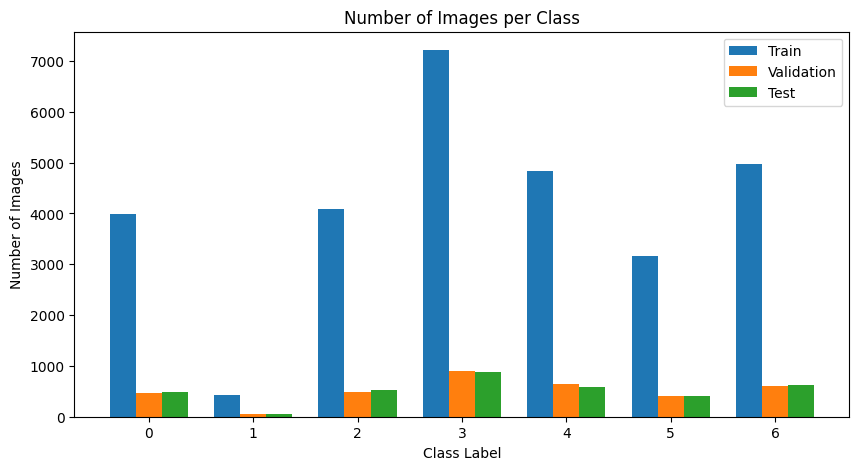

In [5]:

# Count the number of samples per class for each dataset
train_counts = Counter(y_train)
val_counts = Counter(y_val)
test_counts = Counter(y_test)

# Get sorted class labels
class_labels = sorted(set(y_train) | set(y_val) | set(y_test))

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.25
index = np.arange(len(class_labels))

ax.bar(index, [train_counts[c] for c in class_labels], bar_width, label='Train')
ax.bar(index + bar_width, [val_counts[c] for c in class_labels], bar_width, label='Validation')
ax.bar(index + 2 * bar_width, [test_counts[c] for c in class_labels], bar_width, label='Test')

ax.set_xlabel('Class Label')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(class_labels)
ax.legend()

plt.show()

Here I take the target number of images in each class is 4000. 
For classes with >4000 samples, randomly select 4000. For those with <4000, duplicate random samples until reaching 4000.

Training Transforms:
- ToPILImage(): Converts NumPy arrays to PIL images for compatibility with torchvision.
- Resize(384, 384): Matches EfficientNet V2 Small’s expected input size.
- Grayscale(num_output_channels=3): Converts grayscale FER13 images to 3-channel (RGB) format, as the pretrained model expects RGB.
- RandomRotation(10): Adds ±10° rotation for augmentation, simulating natural variations.
- ToTensor(): Converts to PyTorch tensor format (0–1 range).
- Normalize: Applies ImageNet mean and std to align with pretrained weights.

In [6]:

TARGET_COUNT = 4000

# Count the number of samples per class in training set
train_counts = Counter(y_train)

# Data augmentation for training set
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 384), interpolation=InterpolationMode.BILINEAR),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
    # transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match EfficientNet normalization
])

# **No augmentation for validation and test sets**
val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 384), interpolation=InterpolationMode.BILINEAR),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Balance dataset by removing excess images and augmenting underrepresented classes
balanced_x_train = []
balanced_y_train = []

for label in train_counts:
    indices = [i for i, y in enumerate(y_train) if y == label]
    if train_counts[label] > TARGET_COUNT:
        # Randomly select TARGET_COUNT images
        selected_indices = random.sample(indices, TARGET_COUNT)
    else:
        # Keep all images and perform augmentation to reach TARGET_COUNT
        selected_indices = indices.copy()
        while len(selected_indices) < TARGET_COUNT:
            selected_indices.append(random.choice(indices))
    
    for idx in selected_indices:
        balanced_x_train.append(x_train[idx])
        balanced_y_train.append(y_train[idx])

# Convert balanced dataset to numpy arrays
balanced_x_train = np.array(balanced_x_train)
balanced_y_train = np.array(balanced_y_train)

# Define dataset class
class FERDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].astype(np.uint8)
        label = int(self.labels[idx])
        return self.transform(image), label

# Create datasets with appropriate transforms
datasets = {
    'train': FERDataset(balanced_x_train, balanced_y_train, transform=train_transforms),
    'val': FERDataset(x_val, y_val, transform=val_test_transforms),  # No augmentation
    'test': FERDataset(x_test, y_test, transform=val_test_transforms)  # No augmentation
}

# Get the number of unique classes in the dataset
num_classes = len(np.unique(np.concatenate([y_train, y_val, y_test])))

print(f"Number of classes: {num_classes}")

# Create dataloaders
dataloaders = {
    x: DataLoader(datasets[x], batch_size=batch_size, shuffle=(x == 'train'), num_workers=4)
    for x in ['train', 'val', 'test']
}

# Count final dataset sizes
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}

print(f"Final dataset sizes: {dataset_sizes}")


Number of classes: 7
Final dataset sizes: {'train': 28000, 'val': 3589, 'test': 3589}


In [7]:
dataset_sizes

{'train': 28000, 'val': 3589, 'test': 3589}

Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.31064308..1.7677125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.6892812].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7938564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


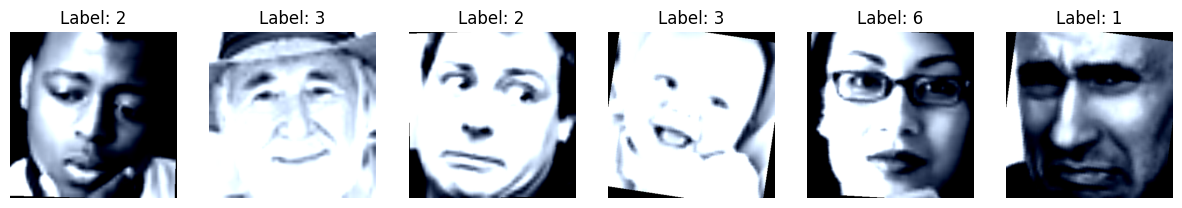

In [8]:
def show_sample_images(dataloader, num_images=6):
    images_shown = 0
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for images, labels in dataloader:
        for i in range(num_images):
            image = images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5
            axes[i].imshow(image, cmap='gray')
            axes[i].set_title(f"Label: {labels[i]}")
            axes[i].axis('off')
            images_shown += 1
            if images_shown >= num_images:
                plt.show()
                return
            
# Show sample images
show_sample_images(dataloaders['train'])

Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

Key Components:
- Combined Metric: 0.5 * (accuracy + f1_score) balances precision/recall and overall correctness.
- Training Loop: Iterates over epochs and phases (train/val).
- Model Modes: model.train() enables dropout/BatchNorm updates; model.eval() disables them.
- Gradient Clipping: Prevents exploding gradients with max_norm=1.0.
- Scheduler: Adjusts learning rate (StepLR or OneCycleLR).
- Early Stopping: Stops if validation metric doesn’t improve for patience epochs.
- Visualization: Plots loss, accuracy, F1, combined metric, and learning rate trends.


In [9]:

# Function to calculate combined metric
def calculate_combined_metric(accuracy, f1_score):
    return 0.5 * (accuracy + f1_score)

# Modified training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5, grad_clip=1.0):
    since = time.time()
    
    # Create models directory
    model_dir = "models"
    os.makedirs(model_dir, exist_ok=True)
    best_model_path = os.path.join(model_dir, 'best_model.pth')
    
    best_combined_metric = 0.0
    patience_counter = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_f1_scores, val_f1_scores = [], []
    train_combined_metrics, val_combined_metrics = [], []
    learning_rates = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        # Gradient clipping to prevent exploding gradients
                        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Collect predictions and labels for F1 score
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            
            # Step the scheduler after the epoch (for OneCycleLR)
            if phase == 'train':
                scheduler.step()
                # Log the learning rate
                current_lr = optimizer.param_groups[0]['lr']
                learning_rates.append(current_lr)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
            epoch_combined_metric = calculate_combined_metric(epoch_acc.item(), epoch_f1)
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
                train_f1_scores.append(epoch_f1)
                train_combined_metrics.append(epoch_combined_metric)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())
                val_f1_scores.append(epoch_f1)
                val_combined_metrics.append(epoch_combined_metric)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f} Combined: {epoch_combined_metric:.4f}')
            
            if phase == 'val' and epoch_combined_metric > best_combined_metric:
                best_combined_metric = epoch_combined_metric
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'best_combined_metric': best_combined_metric,
                }, best_model_path)
                patience_counter = 0  # Reset early stopping counter
            elif phase == 'val':
                patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Combined Metric: {best_combined_metric:.4f}')
    
    # Load best model
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Plot training results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')
    
    plt.subplot(2, 3, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')
    
    plt.subplot(2, 3, 3)
    plt.plot(train_f1_scores, label='Train F1')
    plt.plot(val_f1_scores, label='Val F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('Training & Validation F1 Score')
    
    plt.subplot(2, 3, 4)
    plt.plot(train_combined_metrics, label='Train Combined')
    plt.plot(val_combined_metrics, label='Val Combined')
    plt.xlabel('Epochs')
    plt.ylabel('Combined Metric')
    plt.legend()
    plt.title('Training & Validation Combined Metric')
    
    plt.subplot(2, 3, 5)
    plt.plot(learning_rates, label='Learning Rate')
    plt.xlabel('Steps')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.title('Learning Rate Schedule')
    
    plt.tight_layout()
    plt.show()
    
    return model

Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [10]:
# Function to unnormalize and show an image
def imshow(img):
    """Display a tensor image (Grayscale or RGB)"""
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor format (C, H, W) to (H, W, C)
    img = img * 0.5 + 0.5  # Unnormalize (assuming Normalize([0.5], [0.5]))
    
    if img.shape[-1] == 1:  # If the image is grayscale, remove the last dimension
        img = img.squeeze(-1)
    
    plt.imshow(img, cmap="gray" if len(img.shape) == 2 else None)  # Use 'gray' colormap if grayscale
    plt.axis("off")

# Function to visualize model predictions
def visualize_model(model, num_images=6):
    """Visualizes model predictions on the validation set"""
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, num_images * 2))

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot((num_images + 1) // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f'Predicted: {preds[j].item()} | True: {labels[j].item()}')
                
                imshow(inputs.cpu().data[j])  # Show image

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    model.train(mode=was_training)

In [11]:
def evaluate_model(model, dataloader, num_classes, device):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []
    y_prob = []  # Store probability scores for AUC calculation

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Forward pass

            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            _, preds = torch.max(outputs, 1)  # Get predicted class

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())  # Store probabilities

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Compute classification report (Precision, Recall, F1-score)
    class_report = classification_report(y_true, y_pred, digits=4)

    # Compute Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    f1 = f1_score(y_true, y_pred, average='weighted')

    # Compute new metric: 0.5*(Accuracy + F1)
    combined_metric = 0.5 * (accuracy + f1)

    # Compute AUC (for multi-class classification using One-vs-Rest)
    y_true_bin = np.eye(num_classes)[y_true]  # Convert to one-hot encoding
    auc_score = roc_auc_score(y_true_bin, np.array(y_prob), multi_class="ovr")

    return cm, accuracy, auc_score, class_report, combined_metric


# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_labels, normalize=False):
    plt.figure(figsize=(9, 8))
    
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row
    
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title("Confusion Matrix", fontsize=20)
    plt.colorbar()

    # Add text annotations
    fmt = ".2f" if normalize else "d"
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, format(cm[i, j], fmt), ha="center", va="center", 
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
    plt.yticks(np.arange(len(class_labels)), class_labels)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("Actual Label", fontsize=14)
    plt.show()

Finetuning the ConvNet
======================


### Baseline model 

We freeze the entire model and unfreeze the classifier

In [12]:
# Step 1: Load and modify the model
model_ft = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
num_ftrs = model_ft.classifier[1].in_features

# Define a small FCN classifier
model_ft.classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout before the first layer
    nn.Linear(num_ftrs, 512),  # First hidden layer
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, num_classes)  # Output layer
)

# Freeze entire model first
for param in model_ft.parameters():
    param.requires_grad = False

# Unfreeze classifier parameters
for param in model_ft.classifier.parameters():
    param.requires_grad = True

model_ft = model_ft.to(device)

# Define loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

# Step 4: Set up optimizer (AdamW is better for weight decay handling)
optimizer_ft = optim.AdamW(model_ft.classifier.parameters(), lr=lr, weight_decay=weight_decay)

# Step 5: One-cycle learning rate scheduler (more stable than cosine)
scheduler = OneCycleLR(optimizer_ft, 
                      max_lr=1e-3, 
                      steps_per_epoch=len(dataloaders['train']), 
                      epochs=num_epochs, 
                      pct_start=0.1)  # Warm-up for 10% of training



#### Train and evaluate
==================

Epoch 0/9
----------
train Loss: 1.9015 Acc: 0.2220 F1: 0.2166 Combined: 0.2193
val Loss: 1.8473 Acc: 0.2605 F1: 0.2559 Combined: 0.2582

Epoch 1/9
----------
train Loss: 1.8250 Acc: 0.2796 F1: 0.2687 Combined: 0.2742
val Loss: 1.8137 Acc: 0.2859 F1: 0.2786 Combined: 0.2822

Epoch 2/9
----------
train Loss: 1.7972 Acc: 0.2935 F1: 0.2818 Combined: 0.2876
val Loss: 1.8109 Acc: 0.2948 F1: 0.2828 Combined: 0.2888

Epoch 3/9
----------
train Loss: 1.7848 Acc: 0.3062 F1: 0.2949 Combined: 0.3006
val Loss: 1.7807 Acc: 0.3076 F1: 0.3054 Combined: 0.3065

Epoch 4/9
----------
train Loss: 1.7737 Acc: 0.3095 F1: 0.2974 Combined: 0.3035
val Loss: 1.7696 Acc: 0.3073 F1: 0.3000 Combined: 0.3037

Epoch 5/9
----------
train Loss: 1.7699 Acc: 0.3100 F1: 0.2985 Combined: 0.3043
val Loss: 1.7756 Acc: 0.3059 F1: 0.3008 Combined: 0.3034
Early stopping triggered!
Training complete in 17m 33s
Best val Combined Metric: 0.3065


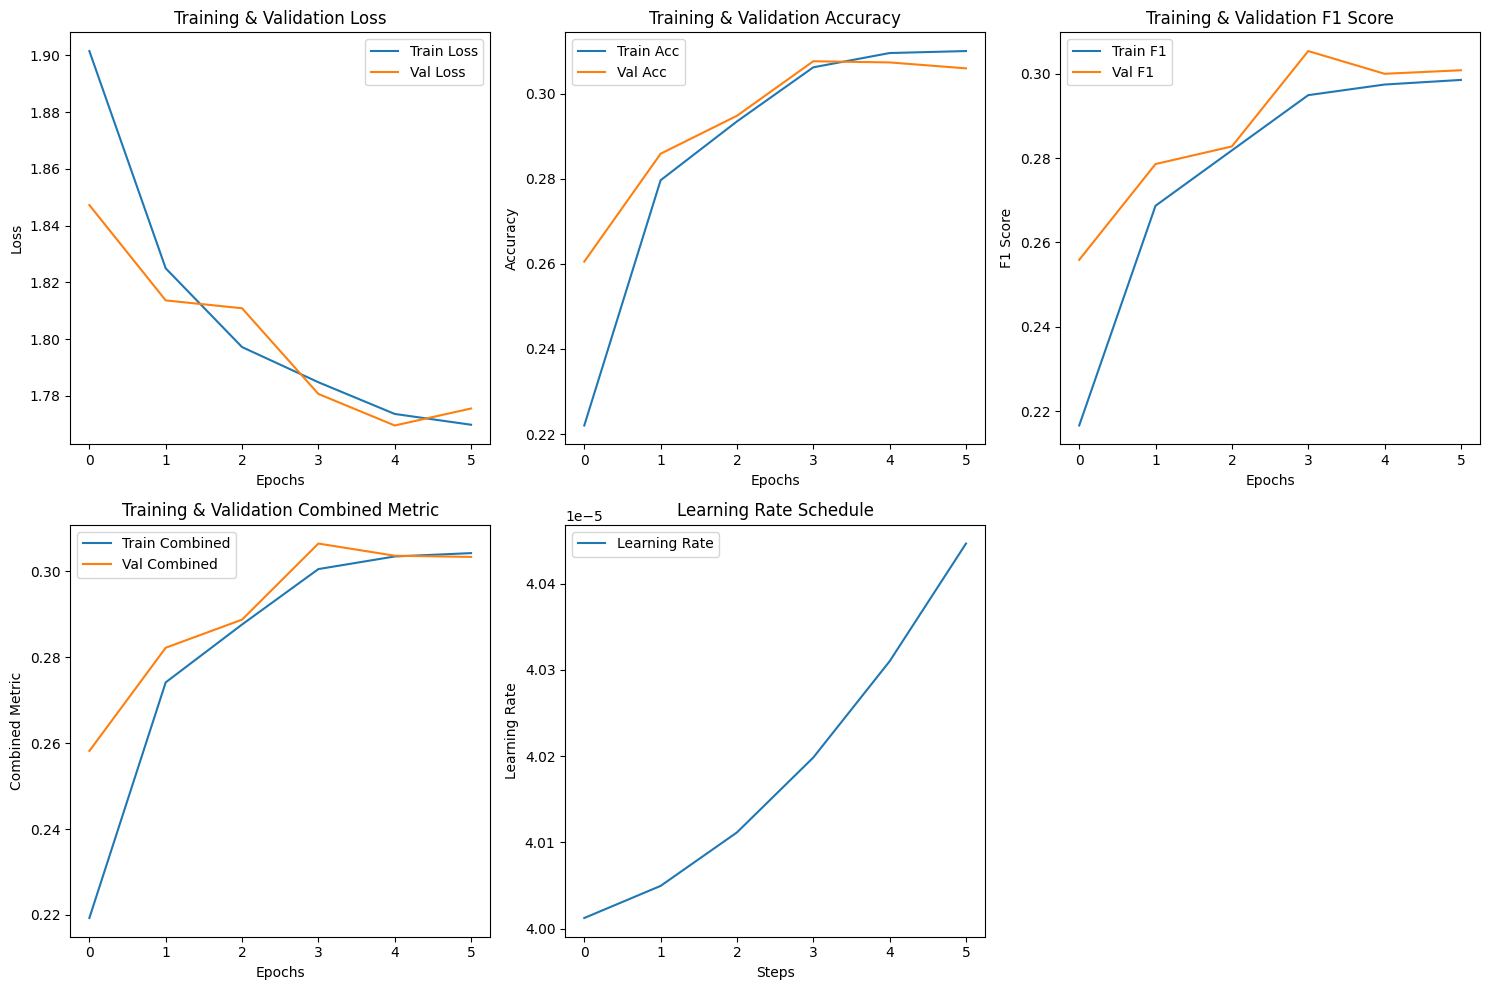

In [13]:
# Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, patience=patience)

Accuracy: 0.3199
AUC Score: 0.7004
0.5*(Accuracy + F1) Score: 0.3189

Classification Report:
               precision    recall  f1-score   support

           0     0.2182    0.1466    0.1754       491
           1     0.0433    0.2364    0.0732        55
           2     0.1979    0.1458    0.1679       528
           3     0.5029    0.3902    0.4395       879
           4     0.3325    0.2121    0.2590       594
           5     0.4020    0.5865    0.4770       416
           6     0.3027    0.4361    0.3573       626

    accuracy                         0.3199      3589
   macro avg     0.2856    0.3077    0.2785      3589
weighted avg     0.3372    0.3199    0.3179      3589



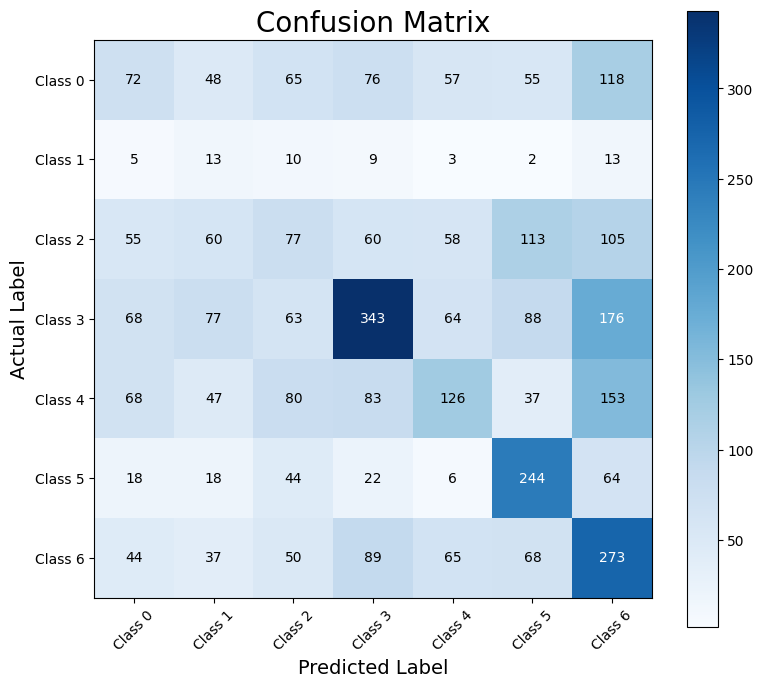

In [14]:
# Example usage:
cm, accuracy, auc_score, class_report, combined_metric = evaluate_model(model_ft, dataloaders['test'], num_classes=num_classes, device="cuda")

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print(f"0.5*(Accuracy + F1) Score: {combined_metric:.4f}")
print("\nClassification Report:\n", class_report)

# Plot confusion matrix
plot_confusion_matrix(cm, class_labels=[f"Class {i}" for i in range(num_classes)], normalize=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7067103].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5332649..1.6892812].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4048292..1.6369936].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.45620346..1.6892812].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.7067103].


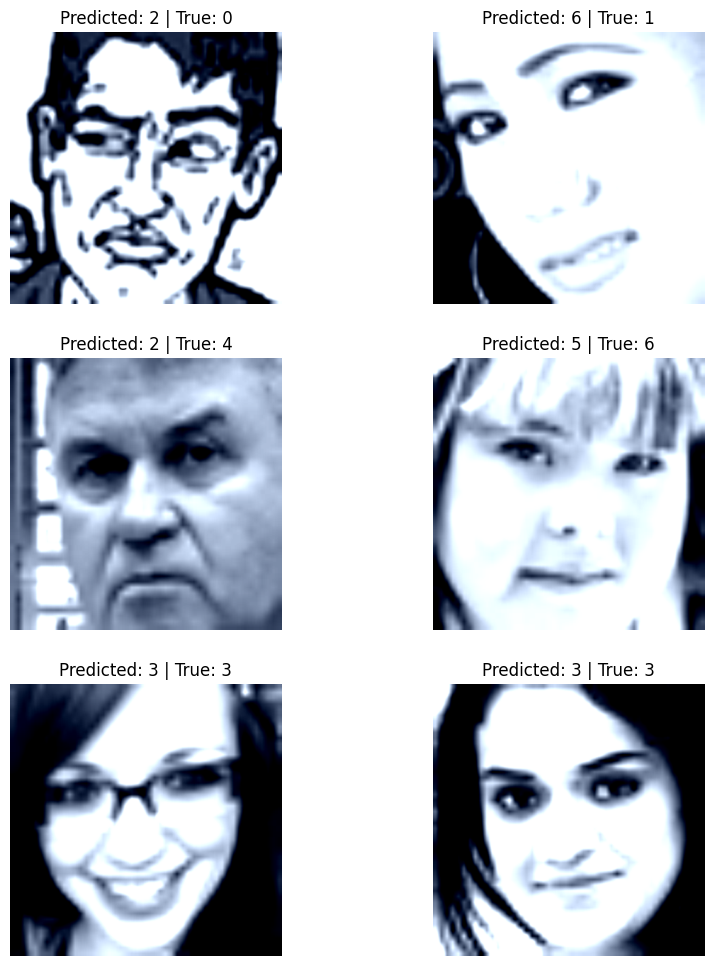

In [15]:
visualize_model(model_ft)

### Variation 1 

Model Setup:
- Uses pretrained EfficientNet V2 Small, replacing the classifier with a custom one (Dropout, Linear, BatchNorm, ReLU, Linear).
- Freezes all layers except the classifier and last feature block (features[7] in EfficientNet-V2-S)

Training:
- Optimizer: AdamW with trainable parameters only.
- Scheduler: StepLR reduces learning rate every 7 epochs.

Results:
- Accuracy: 0.3675, Combined Metric: 0.3610.
- Performance is modest, likely due to limited fine-tuning.

In [16]:
def create_model_v1(num_classes, device):
    model_v1 = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
    num_ftrs = model_v1.classifier[1].in_features

    # Define custom classifier
    model_v1.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, num_classes)
    )

    # Freeze entire model first
    for param in model_v1.parameters():
        param.requires_grad = False

    # Unfreeze classifier
    for param in model_v1.classifier.parameters():
        param.requires_grad = True

    # Unfreeze last feature block (features[7] in EfficientNet-V2-S)
    for param in model_v1.features[7].parameters():
        param.requires_grad = True

    return model_v1.to(device)

In [17]:
# Model 1 training
model_v1 = create_model_v1(num_classes, device)
criterion_v1 = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
optimizer_v1 = optim.AdamW(filter(lambda p: p.requires_grad, model_v1.parameters()), 
                         lr=lr, weight_decay=weight_decay)
scheduler_v1 = OneCycleLR(optimizer_v1, 
                         max_lr=1e-3, 
                         steps_per_epoch=len(dataloaders['train']), 
                         epochs=num_epochs, 
                         pct_start=0.1)

Epoch 0/9
----------
train Loss: 1.8843 Acc: 0.2330 F1: 0.2268 Combined: 0.2299
val Loss: 1.8263 Acc: 0.2758 F1: 0.2659 Combined: 0.2709

Epoch 1/9
----------
train Loss: 1.7966 Acc: 0.2963 F1: 0.2837 Combined: 0.2900
val Loss: 1.8923 Acc: 0.2803 F1: 0.2866 Combined: 0.2834

Epoch 2/9
----------
train Loss: 1.7640 Acc: 0.3204 F1: 0.3076 Combined: 0.3140
val Loss: 1.7843 Acc: 0.2979 F1: 0.2927 Combined: 0.2953

Epoch 3/9
----------
train Loss: 1.7421 Acc: 0.3267 F1: 0.3140 Combined: 0.3203
val Loss: 1.7583 Acc: 0.3190 F1: 0.3148 Combined: 0.3169

Epoch 4/9
----------
train Loss: 1.7254 Acc: 0.3361 F1: 0.3230 Combined: 0.3296
val Loss: 1.7394 Acc: 0.3288 F1: 0.3234 Combined: 0.3261

Epoch 5/9
----------
train Loss: 1.7189 Acc: 0.3438 F1: 0.3303 Combined: 0.3371
val Loss: 1.7411 Acc: 0.3299 F1: 0.3238 Combined: 0.3268

Epoch 6/9
----------
train Loss: 1.7037 Acc: 0.3493 F1: 0.3361 Combined: 0.3427
val Loss: 1.7069 Acc: 0.3486 F1: 0.3364 Combined: 0.3425

Epoch 7/9
----------
train Loss: 1

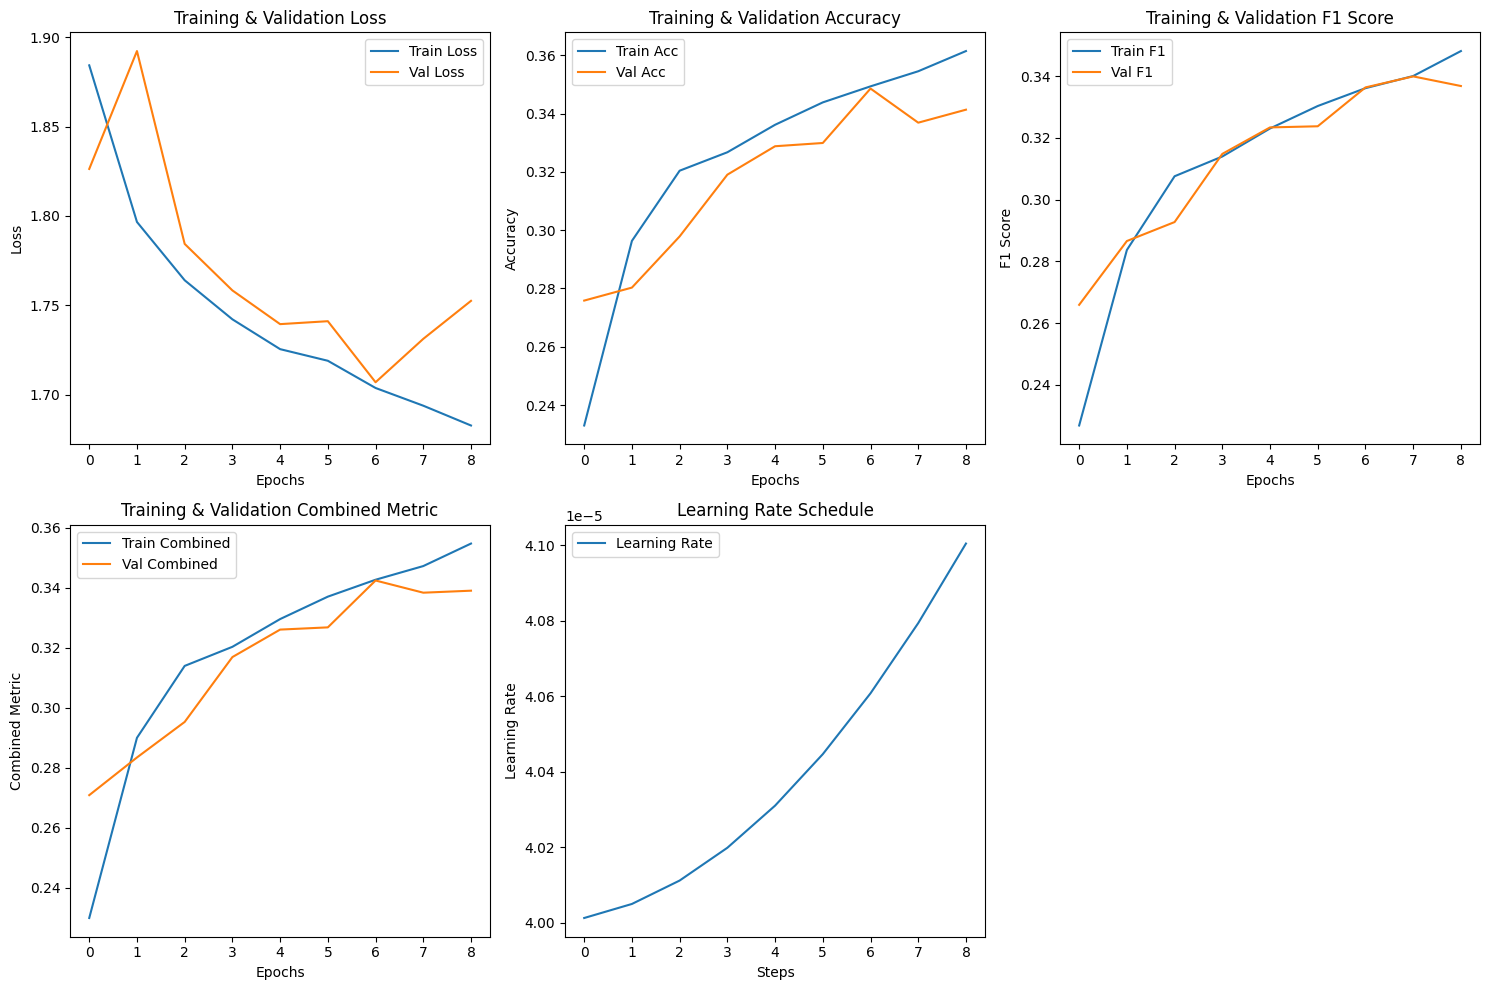

In [18]:
model_v1 = train_model(model_v1, criterion_v1, optimizer_v1, scheduler_v1, num_epochs=num_epochs, patience=patience)

#### Train and evaluate

Accuracy: 0.3675
AUC Score: 0.7436
0.5*(Accuracy + F1) Score: 0.3610

Classification Report:
               precision    recall  f1-score   support

           0     0.3074    0.1609    0.2112       491
           1     0.0750    0.4364    0.1280        55
           2     0.2344    0.0852    0.1250       528
           3     0.5578    0.4937    0.5238       879
           4     0.3174    0.3586    0.3368       594
           5     0.3898    0.7524    0.5135       416
           6     0.3715    0.3371    0.3534       626

    accuracy                         0.3675      3589
   macro avg     0.3219    0.3749    0.3131      3589
weighted avg     0.3768    0.3675    0.3545      3589



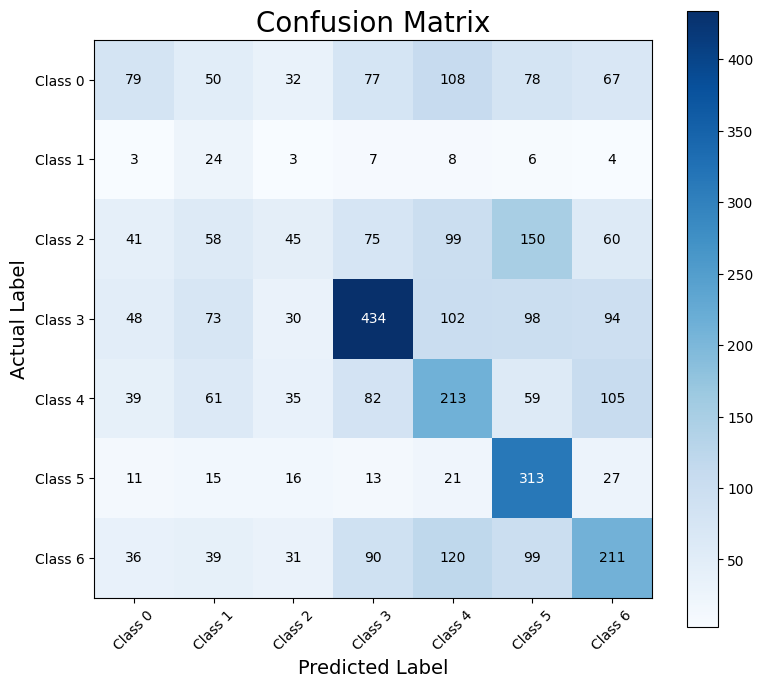

In [19]:
# Example usage:
cm, accuracy, auc_score, class_report, combined_metric = evaluate_model(model_v1, dataloaders['test'], num_classes=num_classes, device="cuda")

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print(f"0.5*(Accuracy + F1) Score: {combined_metric:.4f}")

print("\nClassification Report:\n", class_report)

# Plot confusion matrix
plot_confusion_matrix(cm, class_labels=[f"Class {i}" for i in range(num_classes)], normalize=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7067103].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5332649..1.6892812].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4048292..1.6369936].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.45620346..1.6892812].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.7067103].


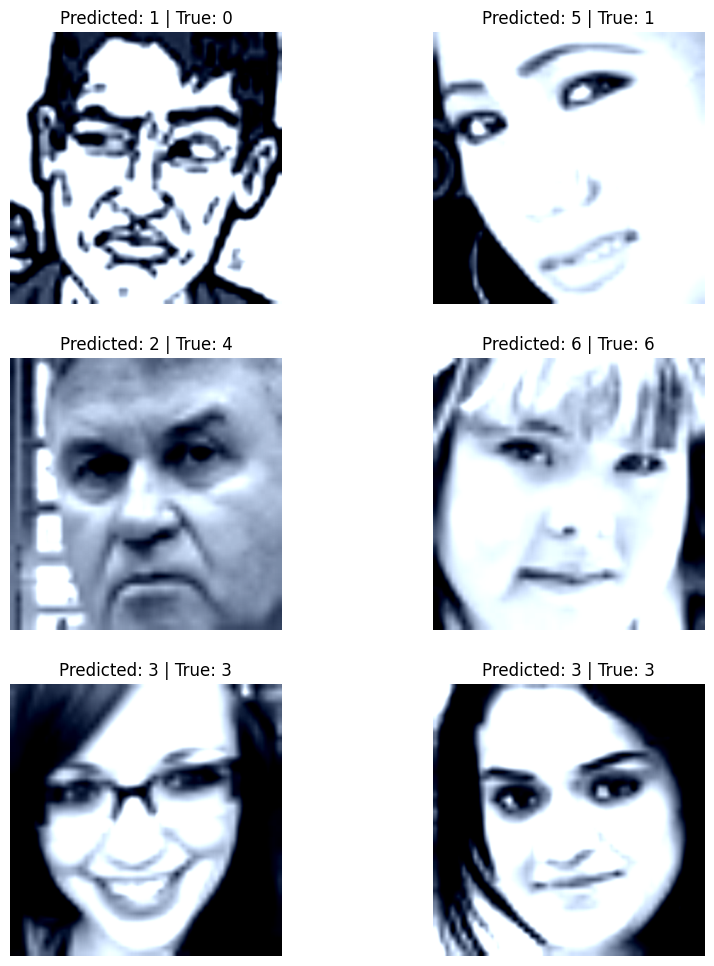

In [20]:
visualize_model(model_v1)

### Variation 2

Model Setup:
- Same classifier as V1, but unfreezes features[6] and features[7] (last two blocks).

Training:
- Uses OneCycleLR for dynamic learning rate adjustment.

Results:
- Accuracy: 0.6640, Combined Metric: 0.6608.
- Significant improvement over V1, as more layers adapt to the FER13 dataset.

In [21]:
# Variation 2: Unfreeze classifier + last two feature blocks
def create_model_v2(num_classes, device):
    model_v2 = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
    num_ftrs = model_v2.classifier[1].in_features

    # Define custom classifier
    model_v2.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, num_classes)
    )

    # Freeze entire model first
    for param in model_v2.parameters():
        param.requires_grad = False

    # Unfreeze classifier
    for param in model_v2.classifier.parameters():
        param.requires_grad = True

    # Unfreeze last two feature blocks (features[6] and features[7])
    for block in [6, 7]:
        for param in model_v2.features[block].parameters():
            param.requires_grad = True

    return model_v2.to(device)

In [22]:
# Model 2 training
model_v2 = create_model_v2(num_classes, device)
criterion_v2 = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
optimizer_v2 = optim.AdamW(filter(lambda p: p.requires_grad, model_v2.parameters()), 
                         lr=lr, weight_decay=weight_decay)
scheduler_v2 = OneCycleLR(optimizer_v2, 
                         max_lr=1e-3, 
                         steps_per_epoch=len(dataloaders['train']), 
                         epochs=num_epochs, 
                         pct_start=0.1)

Epoch 0/9
----------
train Loss: 1.7131 Acc: 0.3396 F1: 0.3213 Combined: 0.3305
val Loss: 1.4595 Acc: 0.4714 F1: 0.4600 Combined: 0.4657

Epoch 1/9
----------
train Loss: 1.3277 Acc: 0.5319 F1: 0.5160 Combined: 0.5239
val Loss: 1.2604 Acc: 0.5522 F1: 0.5401 Combined: 0.5462

Epoch 2/9
----------
train Loss: 1.1553 Acc: 0.6095 F1: 0.6002 Combined: 0.6048
val Loss: 1.1883 Acc: 0.5926 F1: 0.5800 Combined: 0.5863

Epoch 3/9
----------
train Loss: 1.0654 Acc: 0.6489 F1: 0.6418 Combined: 0.6453
val Loss: 1.1567 Acc: 0.6069 F1: 0.5971 Combined: 0.6020

Epoch 4/9
----------
train Loss: 0.9977 Acc: 0.6792 F1: 0.6739 Combined: 0.6765
val Loss: 1.1276 Acc: 0.6227 F1: 0.6199 Combined: 0.6213

Epoch 5/9
----------
train Loss: 0.9484 Acc: 0.7023 F1: 0.6983 Combined: 0.7003
val Loss: 1.1209 Acc: 0.6314 F1: 0.6235 Combined: 0.6275

Epoch 6/9
----------
train Loss: 0.9010 Acc: 0.7219 F1: 0.7189 Combined: 0.7204
val Loss: 1.1186 Acc: 0.6442 F1: 0.6421 Combined: 0.6431

Epoch 7/9
----------
train Loss: 0

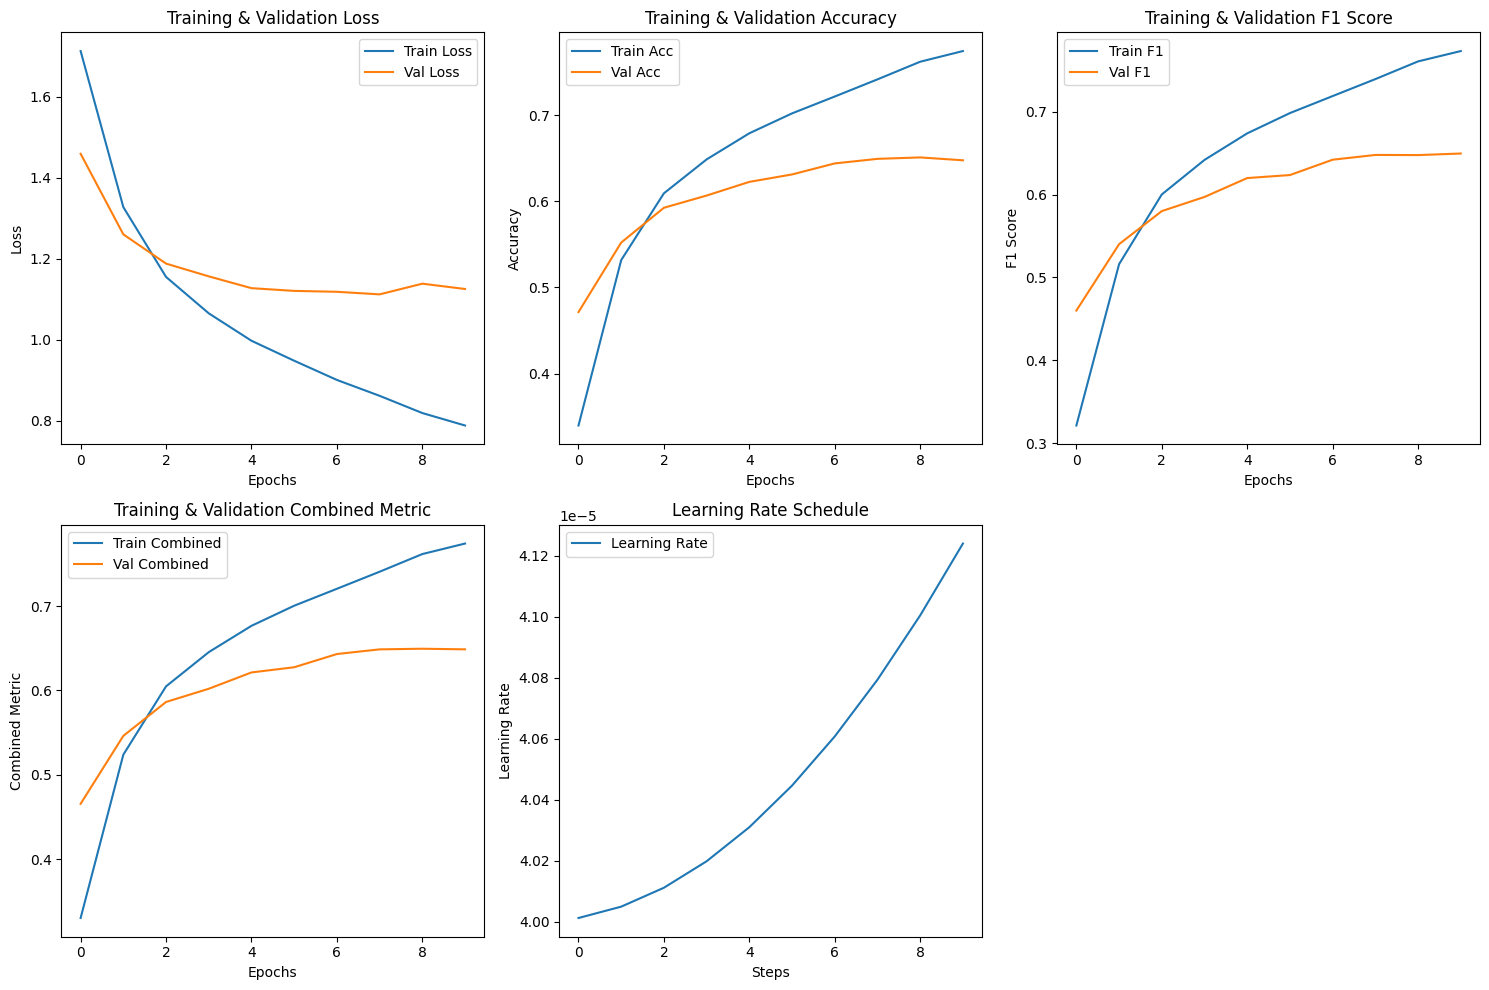

In [23]:
model_v2 = train_model(model_v2, criterion_v2, optimizer_v2, scheduler_v2, num_epochs=num_epochs, patience=patience)

#### Train and evaluate

Accuracy: 0.6640
AUC Score: 0.9119
0.5*(Accuracy + F1) Score: 0.6608

Classification Report:
               precision    recall  f1-score   support

           0     0.5917    0.6375    0.6137       491
           1     0.8163    0.7273    0.7692        55
           2     0.5782    0.3920    0.4673       528
           3     0.9011    0.8294    0.8637       879
           4     0.5639    0.4310    0.4885       594
           5     0.6944    0.8630    0.7696       416
           6     0.5487    0.7652    0.6391       626

    accuracy                         0.6640      3589
   macro avg     0.6706    0.6636    0.6587      3589
weighted avg     0.6687    0.6640    0.6576      3589



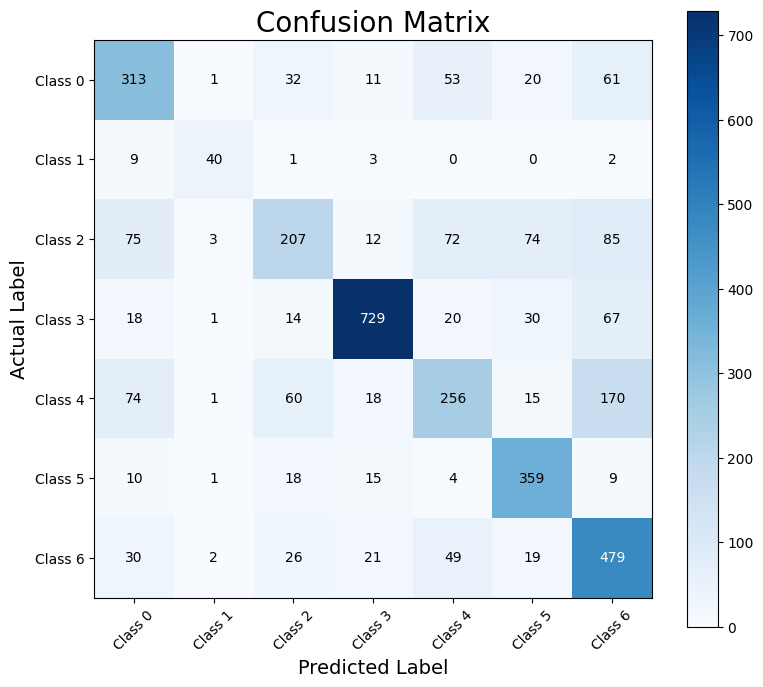

In [24]:
cm, accuracy, auc_score, class_report, combined_metric = evaluate_model(model_v2, dataloaders['test'], num_classes=num_classes, device="cuda")

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print(f"0.5*(Accuracy + F1) Score: {combined_metric:.4f}")
print("\nClassification Report:\n", class_report)

# Plot confusion matrix
plot_confusion_matrix(cm, class_labels=[f"Class {i}" for i in range(num_classes)], normalize=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7067103].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5332649..1.6892812].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4048292..1.6369936].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.45620346..1.6892812].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.7067103].


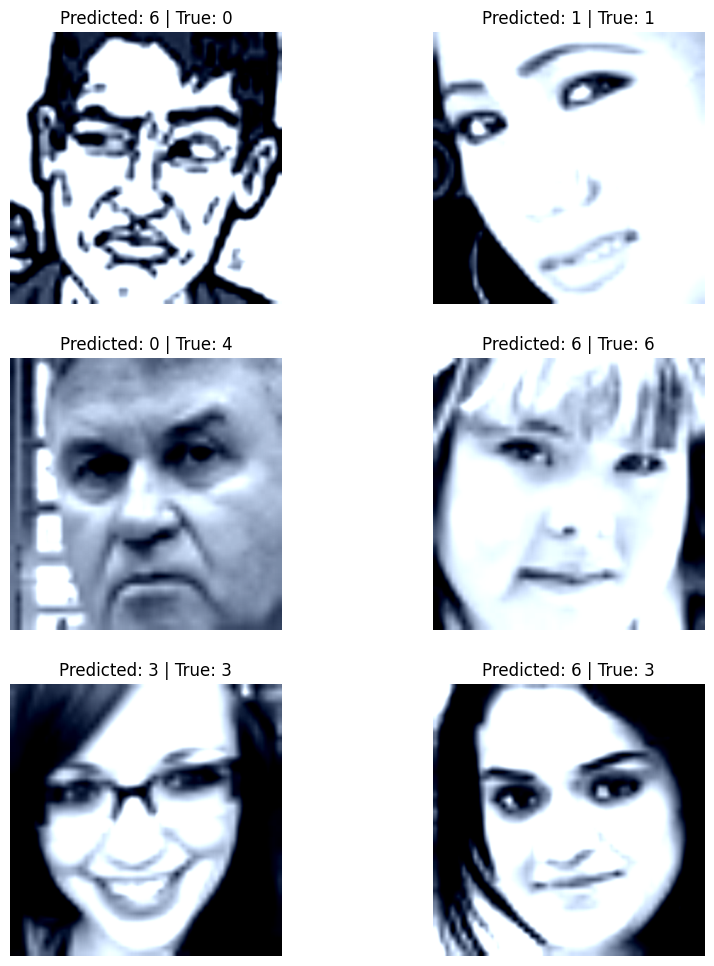

In [25]:
visualize_model(model_v2)

# Conclusion

## Model Descriptions

### Baseline Model
- **Architecture**: EfficientNet V2 Small with a custom classifier:
  - Dropout (p=0.5)
  - Linear (in_features=1280, out_features=512)
  - BatchNorm1d (512)
  - ReLU
  - Linear (512, 7)
- **Training**: Relies entirely on ImageNet-pretrained features, with minimal adaptation to the FER13 task.

### Variation 1

- **Architecture**: Same as Baseline model
- **Training**: Only the classifier is unfrozen and trained, leveraging pre-trained features for feature extraction.

### Variation 2
- **Architecture**: Same as Variation 1 for the classifier, but additionally unfreezes the last two feature blocks (`features[6]` and `features[7]`) of EfficientNet V2 Small.
- **Training**: Both the classifier and the last two feature blocks are fine-tuned, allowing deeper adaptation to facial emotion patterns.

---


## Performance Metrics Comparison

### Overall Metrics

| **Metric**            | **Baseline Model** | **Variation 1** | **Variation 2** |
|-----------------------|-------------------|-----------------|-----------------|
| **Accuracy**          | 0.3199            | 0.3675          | **0.6640**         |
| **AUC Score**         | 0.7004            | 0.7436          | **0.9119**          |
| **Combined Metric**   | 0.3189            | 0.3610          | **0.6608**         |
| **Macro F1 Score**    | 0.2785            | 0.3131          | **0.6587**          |
| **Weighted F1 Score** | 0.3179            | 0.3545          | **0.6576**          |

- **Combined Metric**: Calculated as `0.5 * (accuracy + macro_f1_score)` to balance overall correctness and class-wise performance.

### Per-Class Metrics (Classification Reports)

#### Baseline Model
| **Class** | **Precision** | **Recall** | **F1-Score** | **Support** |
|-----------|---------------|------------|--------------|-------------|
| 0         | 0.2182        | 0.1466     | 0.1754       | 491         |
| 1         | 0.0433        | 0.2364     | 0.0732       | 55          |
| 2         | 0.1979        | 0.1458     | 0.1679       | 528         |
| 3         | 0.5029        | 0.3902     | 0.4395       | 879         |
| 4         | 0.3325        | 0.2121     | 0.2590       | 594         |
| 5         | 0.4020        | 0.5865     | 0.4770       | 416         |
| 6         | 0.3027        | 0.4361     | 0.3573       | 626         |
| **Macro Avg** | 0.2856    | 0.3077     | 0.2785       | 3589        |
| **Weighted Avg** | 0.3372 | 0.3199     | 0.3179       | 3589        |

#### Variation 1
| **Class** | **Precision** | **Recall** | **F1-Score** | **Support** |
|-----------|---------------|------------|--------------|-------------|
| 0         | 0.3074        | 0.1609     | 0.2112       | 491         |
| 1         | 0.0750        | 0.4364     | 0.1280       | 55          |
| 2         | 0.2344        | 0.0852     | 0.1250       | 528         |
| 3         | 0.5578        | 0.4937     | 0.5238       | 879         |
| 4         | 0.3174        | 0.3586     | 0.3368       | 594         |
| 5         | 0.3898        | 0.7524     | 0.5135       | 416         |
| 6         | 0.3715        | 0.3371     | 0.3534       | 626         |
| **Macro Avg** | 0.3219    | 0.3749     | 0.3131       | 3589        |
| **Weighted Avg** | 0.3768 | 0.3675     | 0.3545       | 3589        |

#### Variation 2
| **Class** | **Precision** | **Recall** | **F1-Score** | **Support** |
|-----------|---------------|------------|--------------|-------------|
| 0         | 0.5917        | 0.6375     | 0.6137       | 491         |
| 1         | 0.8163        | 0.7273     | 0.7692       | 55          |
| 2         | 0.5782        | 0.3920     | 0.4673       | 528         |
| 3         | 0.9011        | 0.8294     | 0.8637       | 879         |
| 4         | 0.5639        | 0.4310     | 0.4885       | 594         |
| 5         | 0.6944        | 0.8630     | 0.7696       | 416         |
| 6         | 0.5487        | 0.7652     | 0.6391       | 626         |
| **Macro Avg** | 0.6706    | 0.6636     | 0.6587       | 3589        |
| **Weighted Avg** | 0.6687 | 0.6640     | 0.6576       | 3589        |

### Confusion Matrix Insights
- **Baseline Model**: Likely shows high confusion between minority (e.g., Class 1) and majority classes (e.g., Class 3), with low diagonal values due to poor differentiation.
- **Variation 1**: Improved diagonal elements, but significant misclassifications persist, especially for Classes 2 and 0.
- **Variation 2**: Stronger diagonal dominance, with fewer misclassifications, though Classes 2 and 4 still show weaknesses.

---

## Detailed Analysis

### Overall Performance
- **Baseline Model**: Achieves the lowest accuracy (0.3199) and combined metric (0.3189), with an AUC of 0.7004 indicating moderate discriminative power. The macro F1 (0.2785) is the weakest, reflecting poor performance across all classes.
- **Variation 1**: Improves over the baseline with accuracy (0.3675) and combined metric (0.3610), and a higher AUC (0.7436). The macro F1 (0.3131) shows slight improvement, driven by better majority class performance.
- **Variation 2**: Outperforms both with accuracy (0.6640), AUC (0.9119), and combined metric (0.6608). The macro F1 (0.6587) is significantly higher, indicating balanced performance across classes.

### Per-Class Performance
- **Class 1 (Minority)**:
  - Baseline: F1=0.0732 (high recall 0.2364, low precision 0.0433), suggesting overprediction.
  - Variation 1: F1=0.1280 (recall 0.4364, precision 0.0750), improved recall but still low precision.
  - Variation 2: F1=0.7692 (recall 0.7273, precision 0.8163), excellent balance, benefiting from fine-tuned features.
- **Class 3 (Majority)**:
  - Baseline: F1=0.4395 (recall 0.3902, precision 0.5029), moderate performance.
  - Variation 1: F1=0.5238 (recall 0.4937, precision 0.5578), better due to classifier tuning.
  - Variation 2: F1=0.8637 (recall 0.8294, precision 0.9011), outstanding due to deeper adaptation.
- **Class 2 and 4 (Underperforming)**:
  - All models struggle, with F1 scores ranging from 0.1679–0.4673 (Class 2) and 0.2590–0.4885 (Class 4). Variation 2 improves but not sufficiently, suggesting these emotions are harder to distinguish.



### Strengths and Weaknesses

#### Baseline Model
- **Strengths**: Uses pre-trained features, providing a starting point with minimal computational cost.
- **Weaknesses**: Poor generalization due to no feature adaptation, especially for minority classes (e.g., Class 1 F1=0.0732).
- **Cause**: Reliance on ImageNet features misaligned with facial emotions, compounded by test set imbalance.

#### Variation 1
- **Strengths**: Improved accuracy (0.3675) and AUC (0.7436) over baseline, with better performance on majority classes (e.g., Class 5 F1=0.5135).
- **Weaknesses**: Still weak on minority classes (e.g., Class 1 F1=0.1280) and Classes 2 and 0.
- **Cause**: Limited to classifier tuning, insufficient for capturing emotion-specific features; test set imbalance affects evaluation.

#### Variation 2
- **Strengths**: Excellent overall performance (accuracy 0.6640, AUC 0.9119), with strong minority class results (e.g., Class 1 F1=0.7692) and majority class dominance (e.g., Class 3 F1=0.8637).
- **Weaknesses**: Suboptimal performance on Classes 2 (F1=0.4673) and 4 (F1=0.4885), indicating persistent challenges.
- **Cause**: Deeper fine-tuning enhances feature learning, but test set imbalance and inherent difficulty in distinguishing certain emotions (e.g., sadness vs. neutral) limit perfection.

### Why Variation 2 Outperforms
- **Deeper Fine-Tuning**: Training feature blocks adapts the model to FER13-specific patterns, unlike the baseline and Variation 1.
- **Balanced Training**: The balanced training set (4000 per class) reduces bias, aiding Variation 2’s superior performance.

---

## Causes of Results

### Strengths
- **Pre-trained Backbone**: EfficientNet V2 Small’s strong feature extraction benefits all models.
- **Balanced Training**: Ensures equitable learning across classes, boosting Variation 2.
- **Custom Classifier**: Variation 1 and 2 benefit from a deeper classifier structure compared to a basic baseline.

### Weaknesses
- **Test Set Imbalance**: Minority classes (e.g., Class 1 with 55 samples) skew evaluation, affecting all models but more severely the baseline and Variation 1.
- **Feature Misalignment**: Baseline’s frozen features and Variation 1’s limited tuning fail to capture emotion nuances.
- **Class Complexity**: Classes 2 and 4 may represent emotions (e.g., fear, sadness) harder to distinguish due to subtle visual cues.

## Future Work: Improving the Models

To enhance performance, consider the following strategies:

1. **Balance Evaluation Sets**:
   - Apply balancing techniques to validation and test sets or use weighted metrics to adjust for imbalance.
2. **Advanced Data Augmentation**:
   - Implement CutMix, MixUp, or emotion-specific augmentations to diversify training data.
3. **Class Weighting**:
   - Use class-weighted loss (e.g., inverse frequency) to prioritize minority classes.
4. **Ensemble Methods**:
   - Combine predictions from multiple models (e.g., EfficientNet variants) for robustness.
5. **Fine-Tune More Layers**:
   - Experiment with unfreezing additional feature blocks to optimize feature extraction further.
6. **Alternative Architectures**:
   - Test models pre-trained on face-related tasks (e.g., VGGFace) for better initial features.
7. **Hyperparameter Tuning**:
   - Optimize learning rate, dropout, and batch size via grid search or automated methods.
8. **Synthetic Data**:
   - Use GANs to generate additional samples for minority classes.

---